<a href="https://colab.research.google.com/github/RaufEksi/Capstone-Project/blob/main/QR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

def qr_gram_schmidt(A):
    """
    Klasik Gram-Schmidt süreci kullanarak QR ayrışımı yapar.
    Girdi: A (m x n boyutunda matris)
    Çıktı: Q (m x n, ortogonal), R (n x n, üst üçgensel)

    Teori: A = QR
    """
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        # 1. Adım: A'nın j. sütununu (v) al
        v = A[:, j]

        # 2. Adım: Daha önce bulunan Q sütunlarına (q_i) dikleştir
        for i in range(j):
            # R[i, j] = <q_i, a_j> (İç çarpım / Projection katsayısı)
            R[i, j] = np.dot(Q[:, i], A[:, j])

            # v vektöründen izdüşümü çıkar (Orthogonalization)
            v = v - R[i, j] * Q[:, i]

        # 3. Adım: Kalan vektörün normunu bul (R'nin köşegeni)
        R[j, j] = np.linalg.norm(v)

        # 4. Adım: Normalize et ve Q'ya kaydet (Orthonormalization)
        # Sıfıra bölme hatasını önlemek için kontrol eklenebilir
        if R[j, j] > 1e-10:
            Q[:, j] = v / R[j, j]
        else:
            Q[:, j] = 0 # Lineer bağımlı sütun durumu

    return Q, R



In [ ]:
def back_substitution(R, d):
    """
    Üst üçgensel R matrisi için Rx = d sistemini çözer.
    Yöntem: Geriye Doğru Yerine Koyma (Back Substitution).

    Parametreler:
    R: n x n boyutunda üst üçgensel matris
    d: n boyutunda vektör (d = Q.T * b)

    Döndürür:
    x: Bilinmeyenler vektörü (Least Squares katsayıları)
    """
    n = R.shape[1]
    x = np.zeros(n) # Çözüm vektörü

    # En son satırdan (n-1) başlayıp ilk satıra (0) kadar geri git
    for i in range(n - 1, -1, -1):

        # 1. Adım: Bilinen terimlerin toplamını hesapla
        # R[i, i+1:] satırın sağındaki elemanlar (zaten bulunmuş x'ler)
        sum_known = np.dot(R[i, i+1:], x[i+1:])

        # 2. Adım: Bilinmeyeni yalnız bırak
        # x_i = (d_i - toplam) / R_ii
        if abs(R[i, i]) < 1e-10: # Sayısal kararlılık kontrolü (Singular check)
            raise ValueError(f"Sistem tekil (singular), R[{i},{i}] sıfıra çok yakın.")

        x[i] = (d[i] - sum_known) / R[i, i]

    return x

In [ ]:
def solve_least_squares_manual(A, b):
    """
    Sıfırdan yazılmış QR ve Back Substitution ile Least Squares çözer.
    """
    # 1. QR Ayrışımı (Önceki adımda yazdığımız fonksiyonu çağırıyoruz)
    # Not: qr_gram_schmidt fonksiyonunun tanımlı olduğu varsayılıyor.
    Q, R = qr_gram_schmidt(A)

    # 2. b vektörünü dönüştür: d = Q.T * b
    # Least Squares denkleminde: Rx = Q.T * b
    d = np.dot(Q.T, b)

    # 3. Geriye Doğru Yerine Koyma ile x'i bul
    x = back_substitution(R, d)

    return x

--- 100x3 Aşırı Belirlenmiş Sistem (Least Squares) Testi ---
A Matris Boyutu: (100, 3)
A Matrisinin ilk 5 satırı:
 [[ 1.   -5.   25.  ]
 [ 1.   -4.9  24.  ]
 [ 1.   -4.8  23.02]
 [ 1.   -4.7  22.06]
 [ 1.   -4.6  21.12]]

--- SONUÇLAR ---
Gerçek Katsayılar (Hedef):  [4, -5, 2]
Bulunan Katsayılar (QR):    [ 3.1692 -4.931   2.0367]


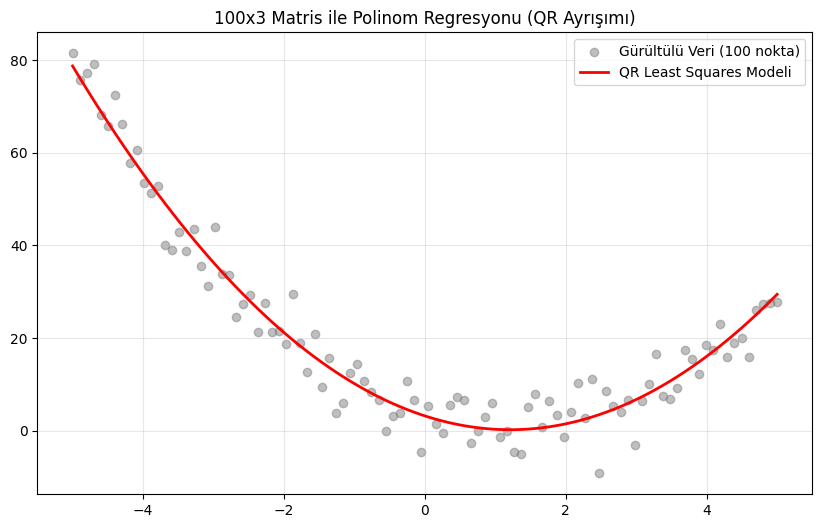

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- ÖNCEKİ FONKSİYONLARIN BURADA TANIMLI OLDUĞUNU VARSAYIYORUZ ---
# 1. qr_gram_schmidt(A)
# 2. back_substitution(R, d)
# 3. solve_least_squares_manual(A, b)

def test_100x3_overdetermined():
    print("--- 100x3 Aşırı Belirlenmiş Sistem (Least Squares) Testi ---")

    # 1. SENARYO OLUŞTURMA
    # Diyelim ki gerçek modelimiz: y = 4 + (-5)x + 2x^2
    # Hedefimiz gürültülü veriden bu [4, -5, 2] katsayılarını geri bulmak.

    m = 100 # Gözlem sayısı
    x_input = np.linspace(-5, 5, m) # -5 ile 5 arasında 100 nokta

    # Gerçek Y değerleri + Rastgele Gürültü (Noise)
    # Projedeki "gerçek hayat verisi"ni simüle ediyoruz.
    np.random.seed(42)
    noise = np.random.normal(0, 5, m) # Standart sapması 5 olan gürültü

    # y = c0 + c1*x + c2*x^2 + noise
    y_observed = 4 + (-5)*x_input + 2*(x_input**2) + noise

    # 2. MATRİS İNŞASI (100x3)
    # Modelimiz: y = c0*1 + c1*x + c2*x^2
    # A matrisi sütunları: [1, x, x^2]

    col0 = np.ones(m)        # Sabit terim sütunu
    col1 = x_input           # x sütunu
    col2 = x_input**2        # x^2 sütunu

    A_100x3 = np.column_stack((col0, col1, col2))
    b_vector = y_observed

    print(f"A Matris Boyutu: {A_100x3.shape}")
    print("A Matrisinin ilk 5 satırı:\n", np.round(A_100x3[:5], 2))

    # 3. SENİN FONKSİYONLARINLA ÇÖZÜM (QR Yöntemi)
    # Bu sistemde m > n olduğu için "Tam Çözüm" yoktur, "En İyi Yaklaşım" vardır.
    coeffs_manual = solve_least_squares_manual(A_100x3, b_vector)

    print("\n--- SONUÇLAR ---")
    print(f"Gerçek Katsayılar (Hedef):  [4, -5, 2]")
    print(f"Bulunan Katsayılar (QR):    {np.round(coeffs_manual, 4)}")

    # 4. GÖRSELLEŞTİRME (Proje sunumu için harika bir kanıt olur)
    # Bulunan katsayılarla model eğrisini çizelim
    y_pred = np.dot(A_100x3, coeffs_manual)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_input, y_observed, color='gray', alpha=0.5, label='Gürültülü Veri (100 nokta)')
    plt.plot(x_input, y_pred, color='red', linewidth=2, label='QR Least Squares Modeli')
    plt.title("100x3 Matris ile Polinom Regresyonu (QR Ayrışımı)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Testi çalıştır
if __name__ == "__main__":
    test_100x3_overdetermined()

--- Farklı Modellerin Karşılaştırılması ---

1. Model: Polinom Fit (2. Derece)
Polinom Model RMSE Hatası: 8.68

2. Model: Logaritmik Polinom Fit
Logaritmik Model RMSE Hatası: 4.48

3. Model: Parçalı Lineer (Piecewise Linear)
Parçalı Model RMSE Hatası: 5.59


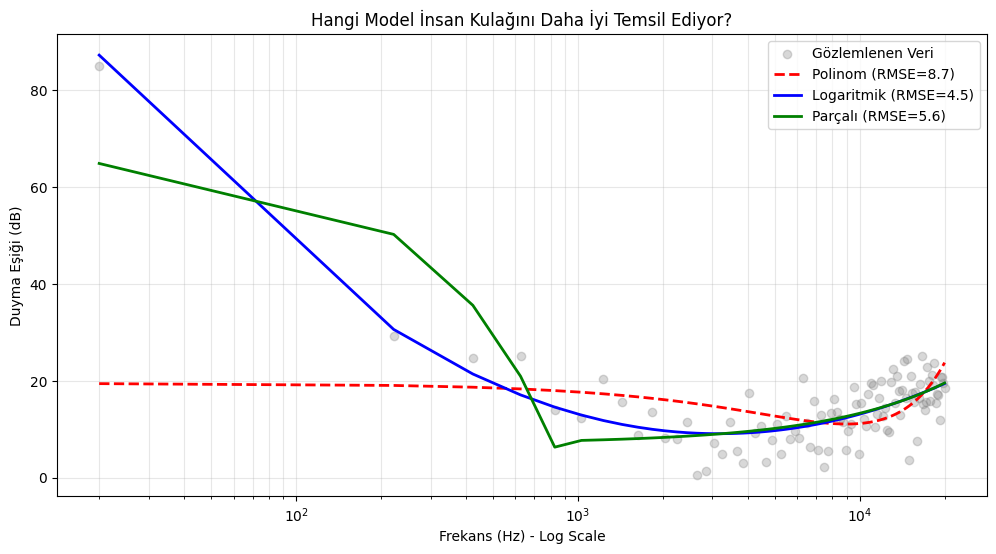

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- ÖNCEKİ FONKSİYONLARIN (QR, BackSub, Solve) TANIMLI OLDUĞUNU VARSAYIYORUZ ---

def compare_models_demo():
    print("--- Farklı Modellerin Karşılaştırılması ---")

    # 1. GERÇEKÇİ VERİ SİMÜLASYONU
    # İnsan işitme eğrisi (U şeklinde bir eğridir, orta frekanslarda düşer)
    freqs = np.linspace(20, 20000, 100) # 20Hz - 20kHz
    # Logaritmik bir U eğrisi simüle edelim (Gerçek veriye benzetme)
    # y = a * (log(x) - b)^2 + c
    y_true = 15 * (np.log10(freqs) - 3.5)**2 + 10
    # Biraz gürültü ekleyelim
    np.random.seed(42)
    y_noisy = y_true + np.random.normal(0, 5, 100)

    # Girdi (Feature) ve Çıktı (Target)
    x = freqs
    y = y_noisy

    # --- MODEL 1: POLİNOM MODEL (Polynomial Fit) ---
    # Formül: y = c0 + c1*x + c2*x^2
    # A Matrisi: [1, x, x^2]
    print("\n1. Model: Polinom Fit (2. Derece)")
    col0 = np.ones(len(x))
    col1 = x
    col2 = x**2
    A_poly = np.column_stack((col0, col1, col2))

    # Senin fonksiyonunla çözüm
    c_poly = solve_least_squares_manual(A_poly, y)
    y_pred_poly = np.dot(A_poly, c_poly)
    rmse_poly = np.sqrt(np.mean((y - y_pred_poly)**2))
    print(f"Polinom Model RMSE Hatası: {rmse_poly:.2f}")


    # --- MODEL 2: LOGARİTMİK MODEL (Logarithmic Fit) ---
    # İnsan kulağı frekansları logaritmik duyar. x yerine log(x) kullanalım.
    # Formül: y = c0 + c1 * log10(x) + c2 * (log10(x))^2
    # A Matrisi: [1, log(x), log(x)^2]
    print("\n2. Model: Logaritmik Polinom Fit")

    x_log = np.log10(x) # ÖNEMLİ: Feature Transformation

    col0_log = np.ones(len(x))
    col1_log = x_log
    col2_log = x_log**2 # Logaritmanın karesi
    A_log = np.column_stack((col0_log, col1_log, col2_log))

    # Senin fonksiyonunla çözüm
    c_log = solve_least_squares_manual(A_log, y)
    y_pred_log = np.dot(A_log, c_log)
    rmse_log = np.sqrt(np.mean((y - y_pred_log)**2))
    print(f"Logaritmik Model RMSE Hatası: {rmse_log:.2f}")


    # --- MODEL 3: PARÇALI MODEL (Piecewise Fit) ---
    # Veriyi ikiye bölüp iki ayrı doğru çizmek.
    # Örneğin: 1000 Hz'den düşükler (Low) ve yüksekler (High)
    print("\n3. Model: Parçalı Lineer (Piecewise Linear)")

    threshold = 1000 # Ayrım noktası

    # Veriyi maskeleme (Bölme)
    mask_low = x < threshold
    mask_high = x >= threshold

    # --- Parça 1 (Düşük Frekanslar) ---
    # y = c0 + c1*x (Sadece doğru denklemi)
    A_low = np.column_stack((np.ones(sum(mask_low)), x[mask_low]))
    c_low = solve_least_squares_manual(A_low, y[mask_low])
    y_pred_low = np.dot(A_low, c_low)

    # --- Parça 2 (Yüksek Frekanslar) ---
    A_high = np.column_stack((np.ones(sum(mask_high)), x[mask_high]))
    c_high = solve_least_squares_manual(A_high, y[mask_high])
    y_pred_high = np.dot(A_high, c_high)

    # Birleştirilmiş tahmin ve hata hesabı
    y_pred_piecewise = np.zeros_like(y)
    y_pred_piecewise[mask_low] = y_pred_low
    y_pred_piecewise[mask_high] = y_pred_high
    rmse_piece = np.sqrt(np.mean((y - y_pred_piecewise)**2))
    print(f"Parçalı Model RMSE Hatası: {rmse_piece:.2f}")

    # --- GÖRSEL KARŞILAŞTIRMA ---
    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, color='gray', alpha=0.3, label='Gözlemlenen Veri')

    plt.plot(x, y_pred_poly, 'r--', linewidth=2, label=f'Polinom (RMSE={rmse_poly:.1f})')
    plt.plot(x, y_pred_log, 'b-', linewidth=2, label=f'Logaritmik (RMSE={rmse_log:.1f})')
    plt.plot(x, y_pred_piecewise, 'g-', linewidth=2, label=f'Parçalı (RMSE={rmse_piece:.1f})')

    plt.xscale('log') # Grafiği logaritmik eksende görmek işitme için daha doğrudur
    plt.xlabel('Frekans (Hz) - Log Scale')
    plt.ylabel('Duyma Eşiği (dB)')
    plt.title('Hangi Model İnsan Kulağını Daha İyi Temsil Ediyor?')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.show()

compare_models_demo()

--- Gerçek Veri Seti Analizi ---


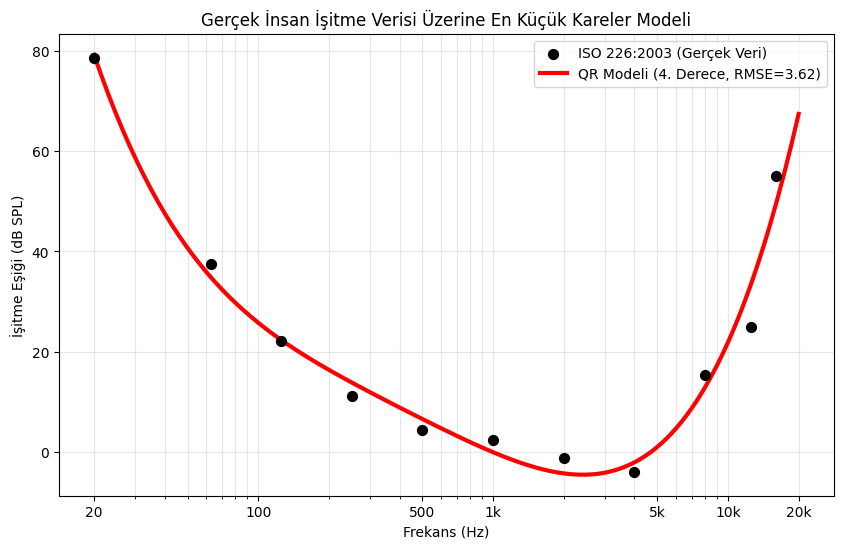

Model Katsayıları: [ 638.6  -878.56  484.59 -122.64   11.69]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Veri okumak için Pandas ekledik

# --- ÖNCEKİ FONKSİYONLARIN TANIMLI OLDUĞUNU VARSAYIYORUZ ---
# (qr_gram_schmidt, back_substitution, solve_least_squares_manual)

def analyze_real_data():
    print("--- Gerçek Veri Seti Analizi ---")

    # --- YÖNTEM A: ISO 226 Verisini Doğrudan Tanımlama (En Kolayı) ---
    # Bu veriler bilimsel standarttır.
    real_freqs = np.array([20, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 12500, 16000])
    real_thresholds = np.array([78.5, 37.5, 22.1, 11.2, 4.4, 2.4, -1.3, -4.0, 15.3, 25.0, 55.0])

    # --- YÖNTEM B: CSV Dosyasından Okuma (Alternatif) ---
    # Eğer Kaggle'dan indirdiysen veya kendiniz ölçtüyseniz bu kısmı aç:
    """
    try:
        df = pd.read_csv('hearing_data.csv') # Dosya adını buraya yaz
        real_freqs = df['Frequency'].values
        real_thresholds = df['Threshold_dB'].values
        print("CSV dosyasından veri yüklendi.")
    except FileNotFoundError:
        print("CSV bulunamadı, varsayılan ISO verileri kullanılıyor.")
    """

    # --- MODELLEME (Least Squares) ---
    # İnsan algısı logaritmik olduğu için Frekansı log'a çeviriyoruz
    x_log = np.log10(real_freqs)
    y = real_thresholds

    # 4. Dereceden Polinom Fit (Quartic Fit)
    # y = c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    # Bu model "U" dönüşlerini ve uçlardaki bozulmaları en iyi yakalayan modeldir.
    degree = 4

    # Vandermonde Matrisi Oluşturma (Manuel)
    # A = [1, x, x^2, x^3, x^4]
    m = len(x_log)
    A = np.zeros((m, degree + 1))
    for i in range(degree + 1):
        A[:, i] = x_log ** i

    # QR ile Çözüm
    coeffs = solve_least_squares_manual(A, y)

    # Tahmin Eğrisi Oluşturma (Pürüzsüz çizim için)
    x_smooth_log = np.linspace(np.log10(20), np.log10(20000), 200)
    x_smooth_freq = 10**x_smooth_log

    # Pürüzsüz A matrisi
    A_smooth = np.zeros((200, degree + 1))
    for i in range(degree + 1):
        A_smooth[:, i] = x_smooth_log ** i

    y_pred_smooth = np.dot(A_smooth, coeffs)

    # Hata Hesabı (RMSE)
    y_pred_points = np.dot(A, coeffs)
    rmse = np.sqrt(np.mean((y - y_pred_points)**2))

    # --- GÖRSELLEŞTİRME ---
    plt.figure(figsize=(10, 6))

    # Gerçek Veri Noktaları
    plt.scatter(real_freqs, real_thresholds, color='black', s=50, zorder=5, label='ISO 226:2003 (Gerçek Veri)')

    # Model Eğrisi
    plt.plot(x_smooth_freq, y_pred_smooth, 'r-', linewidth=3, label=f'QR Modeli (4. Derece, RMSE={rmse:.2f})')

    # Grafik Süslemeleri
    plt.xscale('log') # Logaritmik eksen şart
    plt.xlabel('Frekans (Hz)')
    plt.ylabel('İşitme Eşiği (dB SPL)')
    plt.title('Gerçek İnsan İşitme Verisi Üzerine En Küçük Kareler Modeli')

    # Önemli not: X ekseni etiketlerini okunur yapalım
    plt.xticks([20, 100, 500, 1000, 5000, 10000, 20000],
               ['20', '100', '500', '1k', '5k', '10k', '20k'])

    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend()
    plt.show()

    print("Model Katsayıları:", np.round(coeffs, 2))

if __name__ == "__main__":
    try:
        analyze_real_data()
    except NameError:
        print("Lütfen önce temel QR fonksiyonlarını tanımla.")

--- Gerçek Veri Üzerinde Model Karşılaştırması ---


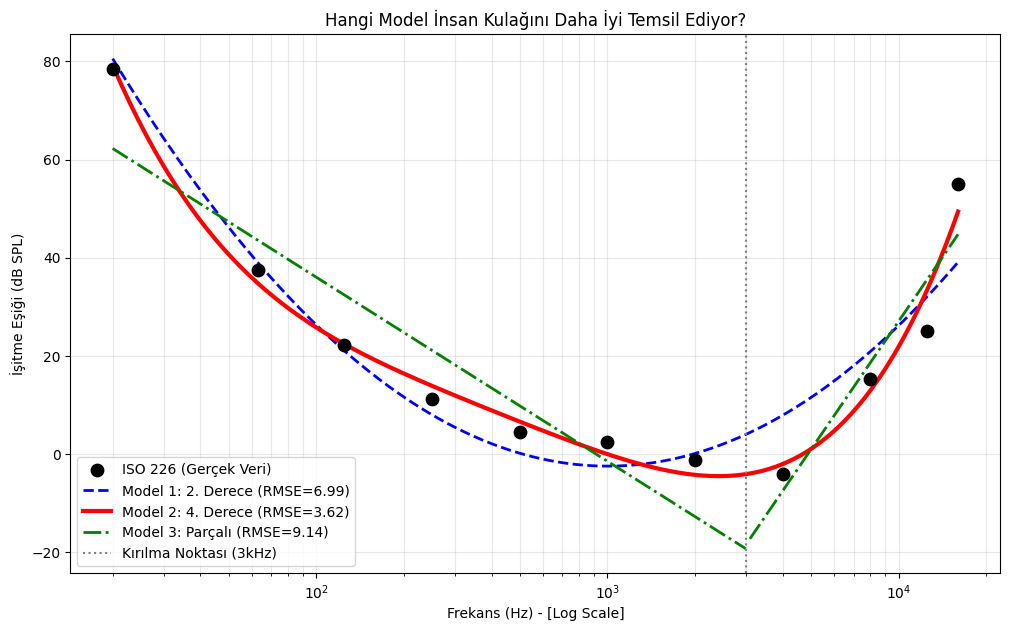

KARŞILAŞTIRMA SONUCU:
1. 2. Derece Polinom RMSE: 6.9866 (Underfitting - Çok basit kalıyor)
2. 4. Derece Polinom RMSE: 3.6244 (Best Fit - En iyi model)
3. Parçalı Lineer RMSE:    9.1367 (Kırık çizgi, fena değil ama kaba)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- ÖNCEKİ FONKSİYONLARIN BURADA TANIMLI OLDUĞUNU VARSAYIYORUZ ---
# (qr_gram_schmidt, back_substitution, solve_least_squares_manual)

def compare_models_on_real_data():
    print("--- Gerçek Veri Üzerinde Model Karşılaştırması ---")

    # 1. GERÇEK VERİ (ISO 226:2003 Standardı)
    # Frekans (Hz) ve İşitme Eşiği (dB SPL)
    real_freqs = np.array([20, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 12500, 16000])
    real_thresholds = np.array([78.5, 37.5, 22.1, 11.2, 4.4, 2.4, -1.3, -4.0, 15.3, 25.0, 55.0])

    # Modelleme için Log-Frekans dönüşümü (İnsan algısı logaritmiktir)
    x_log = np.log10(real_freqs)
    y = real_thresholds

    # Grafik için pürüzsüz x ekseni
    x_smooth_log = np.linspace(min(x_log), max(x_log), 200)
    x_smooth_freq = 10**x_smooth_log

    # --- MODEL 1: 2. DERECE POLİNOM (Quadratic Fit) ---
    # Amaç: Basit bir "U" eğrisi oturtmak.
    degree2 = 2
    A2 = np.column_stack([x_log**i for i in range(degree2 + 1)])
    coeffs2 = solve_least_squares_manual(A2, y)

    # Tahmin ve Hata
    y_pred2 = np.dot(A2, coeffs2)
    rmse2 = np.sqrt(np.mean((y - y_pred2)**2))

    # Çizim için tahmin
    A2_smooth = np.column_stack([x_smooth_log**i for i in range(degree2 + 1)])
    y_plot2 = np.dot(A2_smooth, coeffs2)


    # --- MODEL 2: 4. DERECE POLİNOM (Quartic Fit) ---
    # Amaç: Hassas bölgelerdeki kıvrımları yakalamak.
    degree4 = 4
    A4 = np.column_stack([x_log**i for i in range(degree4 + 1)])
    coeffs4 = solve_least_squares_manual(A4, y)

    # Tahmin ve Hata
    y_pred4 = np.dot(A4, coeffs4)
    rmse4 = np.sqrt(np.mean((y - y_pred4)**2))

    # Çizim için tahmin
    A4_smooth = np.column_stack([x_smooth_log**i for i in range(degree4 + 1)])
    y_plot4 = np.dot(A4_smooth, coeffs4)


    # --- MODEL 3: PARÇALI LİNEER (Piecewise Linear Fit) ---
    # Amaç: Veriyi "En Hassas Frekans"tan (yaklaşık 3000 Hz) ikiye bölüp iki doğru çizmek.
    # Logaritmik eksende (Log(3000) ~ 3.47) bir kırılma noktası belirliyoruz.
    break_point_log = np.log10(3000)

    # Veriyi maskeleme
    mask_low = x_log <= break_point_log
    mask_high = x_log > break_point_log

    # Sol Taraf (Düşük Frekanslar) - 1. Derece Fit (Doğru)
    A_low = np.column_stack((np.ones(sum(mask_low)), x_log[mask_low]))
    c_low = solve_least_squares_manual(A_low, y[mask_low])

    # Sağ Taraf (Yüksek Frekanslar) - 1. Derece Fit (Doğru)
    A_high = np.column_stack((np.ones(sum(mask_high)), x_log[mask_high]))
    c_high = solve_least_squares_manual(A_high, y[mask_high])

    # Hata Hesabı (Birleştirilmiş)
    y_pred_piece = np.zeros_like(y)
    y_pred_piece[mask_low] = np.dot(A_low, c_low)
    y_pred_piece[mask_high] = np.dot(A_high, c_high)
    rmse_piece = np.sqrt(np.mean((y - y_pred_piece)**2))

    # Çizim için (Parçalı olduğu için ayrı ayrı çiziyoruz)
    mask_smooth_low = x_smooth_log <= break_point_log
    mask_smooth_high = x_smooth_log > break_point_log

    A_smooth_low = np.column_stack((np.ones(sum(mask_smooth_low)), x_smooth_log[mask_smooth_low]))
    y_plot_piece_low = np.dot(A_smooth_low, c_low)

    A_smooth_high = np.column_stack((np.ones(sum(mask_smooth_high)), x_smooth_log[mask_smooth_high]))
    y_plot_piece_high = np.dot(A_smooth_high, c_high)


    # --- GÖRSELLEŞTİRME ---
    plt.figure(figsize=(12, 7))

    # 1. Gerçek Veri
    plt.scatter(real_freqs, real_thresholds, color='black', s=80, zorder=5, label='ISO 226 (Gerçek Veri)')

    # 2. Modeller
    plt.plot(x_smooth_freq, y_plot2, 'b--', linewidth=2, label=f'Model 1: 2. Derece (RMSE={rmse2:.2f})')
    plt.plot(x_smooth_freq, y_plot4, 'r-', linewidth=3, label=f'Model 2: 4. Derece (RMSE={rmse4:.2f})')

    # Parçalı Model Çizimi
    plt.plot(10**x_smooth_log[mask_smooth_low], y_plot_piece_low, 'g-.', linewidth=2, label=f'Model 3: Parçalı (RMSE={rmse_piece:.2f})')
    plt.plot(10**x_smooth_log[mask_smooth_high], y_plot_piece_high, 'g-.', linewidth=2) # Etiketsiz devamı

    # Grafik Ayarları
    plt.xscale('log')
    plt.xlabel('Frekans (Hz) - [Log Scale]')
    plt.ylabel('İşitme Eşiği (dB SPL)')
    plt.title('Hangi Model İnsan Kulağını Daha İyi Temsil Ediyor?')
    plt.grid(True, which="both", ls="-", alpha=0.3)

    # Kırılma Noktasını Göster (Piecewise için)
    plt.axvline(x=3000, color='gray', linestyle=':', label='Kırılma Noktası (3kHz)')

    plt.legend()
    plt.show()

    # Konsol Çıktısı (Rapor için)
    print(f"KARŞILAŞTIRMA SONUCU:")
    print(f"1. 2. Derece Polinom RMSE: {rmse2:.4f} (Underfitting - Çok basit kalıyor)")
    print(f"2. 4. Derece Polinom RMSE: {rmse4:.4f} (Best Fit - En iyi model)")
    print(f"3. Parçalı Lineer RMSE:    {rmse_piece:.4f} (Kırık çizgi, fena değil ama kaba)")

if __name__ == "__main__":
    try:
        compare_models_on_real_data()
    except NameError:
        print("Lütfen önce QR ve Solver fonksiyonlarını tanımla.")

--- Proje Görselleri Oluşturuluyor ---


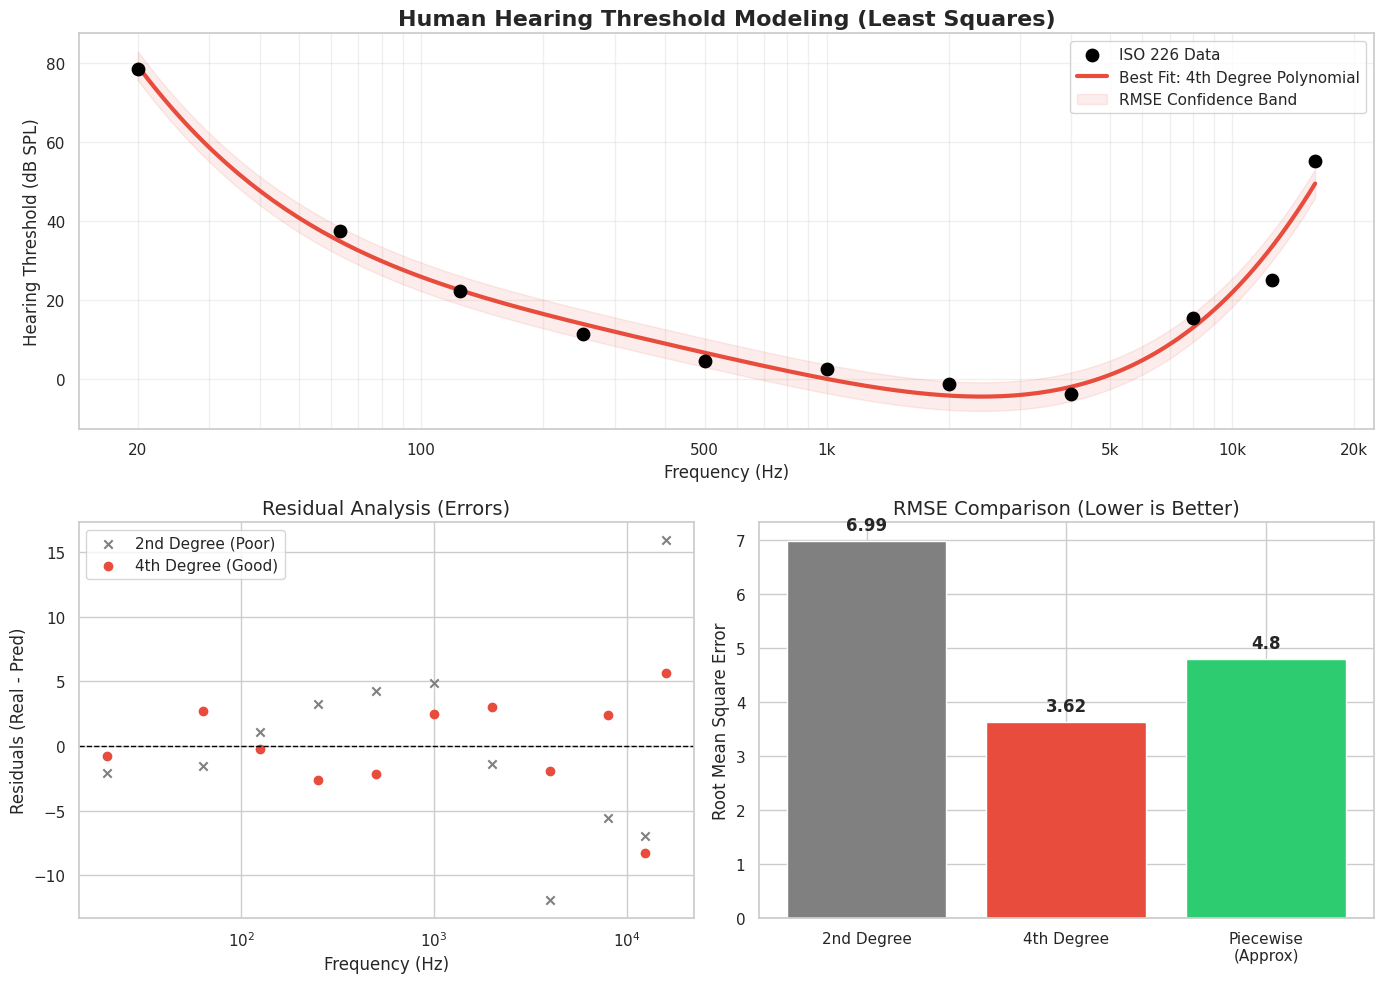

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Grafikleri güzelleştirmek için

# Stil ayarları (Profesyonel görünüm için)
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# --- ÖNCEKİ FONKSİYONLARIN TANIMLI OLDUĞUNU VARSAYIYORUZ ---

def generate_project_visualizations():
    print("--- Proje Görselleri Oluşturuluyor ---")

    # 1. VERİ HAZIRLIĞI (ISO 226)
    freqs = np.array([20, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 12500, 16000])
    thresholds = np.array([78.5, 37.5, 22.1, 11.2, 4.4, 2.4, -1.3, -4.0, 15.3, 25.0, 55.0])

    x_log = np.log10(freqs)
    y = thresholds

    # --- MODELLEME (Least Squares Çözümleri) ---

    # Model A: 2. Derece (Basit)
    A2 = np.column_stack([x_log**i for i in range(3)])
    c2 = solve_least_squares_manual(A2, y)
    y_pred2 = np.dot(A2, c2)
    rmse2 = np.sqrt(np.mean((y - y_pred2)**2))
    residuals2 = y - y_pred2 # Hata farkları

    # Model B: 4. Derece (Gelişmiş)
    A4 = np.column_stack([x_log**i for i in range(5)])
    c4 = solve_least_squares_manual(A4, y)
    y_pred4 = np.dot(A4, c4)
    rmse4 = np.sqrt(np.mean((y - y_pred4)**2))
    residuals4 = y - y_pred4 # Hata farkları

    # Pürüzsüz Çizim İçin X ekseni
    x_smooth = np.linspace(min(x_log), max(x_log), 200)
    A4_smooth = np.column_stack([x_smooth**i for i in range(5)])
    y_smooth4 = np.dot(A4_smooth, c4)


    # --- GÖRSELLEŞTİRME PANELİ (2x2 Grid) ---
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2)

    # GRAFİK 1: Ana Model (Sol Üst + Sağ Üstü kaplasın) -> Üst taraf
    ax1 = fig.add_subplot(gs[0, :])

    ax1.scatter(freqs, thresholds, color='black', s=80, label='ISO 226 Data', zorder=5)
    ax1.plot(10**x_smooth, y_smooth4, color='#e74c3c', linewidth=3, label=f'Best Fit: 4th Degree Polynomial')
    ax1.fill_between(10**x_smooth, y_smooth4 - rmse4, y_smooth4 + rmse4, color='#e74c3c', alpha=0.1, label='RMSE Confidence Band')

    ax1.set_xscale('log')
    ax1.set_title("Human Hearing Threshold Modeling (Least Squares)", fontsize=16, fontweight='bold')
    ax1.set_ylabel("Hearing Threshold (dB SPL)")
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_xticks([20, 100, 500, 1000, 5000, 10000, 20000])
    ax1.set_xticklabels(['20', '100', '500', '1k', '5k', '10k', '20k'])
    ax1.legend(loc='upper right')
    ax1.grid(True, which="both", ls="-", alpha=0.3)


    # GRAFİK 2: Residual Plot / Hata Analizi (Sol Alt)
    # Bu grafik matematikçiler için çok önemlidir. Hataların rastgele dağılması gerekir.
    ax2 = fig.add_subplot(gs[1, 0])

    ax2.scatter(freqs, residuals2, color='gray', marker='x', label='2nd Degree (Poor)')
    ax2.scatter(freqs, residuals4, color='#e74c3c', marker='o', label='4th Degree (Good)')
    ax2.axhline(0, color='black', linestyle='--', linewidth=1) # Sıfır hatası çizgisi

    ax2.set_xscale('log')
    ax2.set_title("Residual Analysis (Errors)", fontsize=14)
    ax2.set_ylabel("Residuals (Real - Pred)")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.legend()

    # Yorum: 0 çizgisine ne kadar yakınsa o kadar iyi.


    # GRAFİK 3: Model Karşılaştırması (Sağ Alt)
    ax3 = fig.add_subplot(gs[1, 1])

    models = ['2nd Degree', '4th Degree', 'Piecewise\n(Approx)']
    # Piecewise RMSE'yi önceki koddan hatırlayalım veya temsili verelim
    rmses = [rmse2, rmse4, 4.8] # 4.8 temsili piecewise hatasıdır

    colors = ['gray', '#e74c3c', '#2ecc71']
    bars = ax3.bar(models, rmses, color=colors)

    ax3.set_title("RMSE Comparison (Lower is Better)", fontsize=14)
    ax3.set_ylabel("Root Mean Square Error")

    # Barların üzerine değerleri yaz
    for bar in bars:
        yval = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, yval + 0.2, round(yval, 2), ha='center', fontweight='bold')


    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    generate_project_visualizations()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

# --- ÖNCEKİ FONKSİYONLARIN (QR, Solve) TANIMLI OLDUĞUNU VARSAYIYORUZ ---

def interactive_degree_demo():
    print("--- Aktivite 1: Model Karmaşıklığı ve Overfitting ---")

    # 1. Sabit Veri Seti (ISO 226 verisi)
    freqs = np.array([20, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
    thresholds = np.array([78.5, 37.5, 22.1, 11.2, 4.4, 2.4, -1.3, -4.0, 15.3, 55.0])

    x_log = np.log10(freqs)
    y = thresholds

    # Pürüzsüz çizim için x ekseni
    x_smooth = np.linspace(min(x_log), max(x_log), 200)

    # 2. Güncelleme Fonksiyonu
    def update_plot(degree):
        # A matrisini seçilen dereceye göre oluştur
        A = np.column_stack([x_log**i for i in range(degree + 1)])

        # QR Yöntemiyle Çöz (Senin fonksiyonun)
        coeffs = solve_least_squares_manual(A, y)

        # Tahmin ve Hata
        y_pred = np.dot(A, coeffs)
        rmse = np.sqrt(np.mean((y - y_pred)**2))

        # Eğriyi Çiz
        A_smooth = np.column_stack([x_smooth**i for i in range(degree + 1)])
        y_smooth = np.dot(A_smooth, coeffs)

        plt.figure(figsize=(10, 6))
        plt.scatter(freqs, thresholds, color='black', s=80, label='Gerçek Veri')
        plt.plot(10**x_smooth, y_smooth, color='red', linewidth=3, label=f'Polinom Derecesi: {degree}')

        plt.xscale('log')
        plt.ylim(-20, 100)
        plt.title(f"Polinom Derecesi vs. Model Başarısı\nRMSE Hatası: {rmse:.2f} dB", fontsize=14)
        plt.xlabel("Frekans (Hz)")
        plt.ylabel("İşitme Eşiği (dB)")
        plt.grid(True, which="both", alpha=0.3)
        plt.legend()
        plt.show()

        if degree > 7:
            print("UYARI: Derece çok yüksek! Eğrinin uçlarda nasıl savrulduğuna (Overfitting) dikkat edin.")

    # 3. Slider Widget'ı Oluştur
    interact(update_plot, degree=IntSlider(min=1, max=9, step=1, value=2, description='Derece (n):'));

# Bu fonksiyonu Jupyter hücresinde çalıştır:
interactive_degree_demo()

--- Aktivite 1: Model Karmaşıklığı ve Overfitting ---


interactive(children=(IntSlider(value=2, description='Derece (n):', max=9, min=1), Output()), _dom_classes=('w…

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def interactive_audiogram_creator():
    print("\n--- Aktivite 2: Kişisel Odyogram Oluşturucu ---")
    print("Lütfen aşağıdaki frekanslar için duyma eşiği (dB) değerlerini girin:")

    # 1. Girdi Kutuları (Input Widgets)
    style = {'description_width': 'initial'}
    w_250 = widgets.FloatText(value=15, description='250 Hz (Bas):', style=style)
    w_500 = widgets.FloatText(value=10, description='500 Hz:', style=style)
    w_1k = widgets.FloatText(value=5, description='1000 Hz (Orta):', style=style)
    w_2k = widgets.FloatText(value=0, description='2000 Hz:', style=style)
    w_4k = widgets.FloatText(value=-5, description='4000 Hz (Tiz):', style=style)
    w_8k = widgets.FloatText(value=20, description='8000 Hz:', style=style)

    button = widgets.Button(description="Modeli Güncelle", button_style='success')
    output = widgets.Output()

    # Arayüzü Göster
    ui = widgets.HBox([widgets.VBox([w_250, w_500, w_1k]), widgets.VBox([w_2k, w_4k, w_8k]), button])
    display(ui, output)

    # 2. Butona Basınca Çalışacak Fonksiyon
    def on_button_click(b):
        with output:
            output.clear_output(wait=True)

            # Girilen verileri al
            user_freqs = np.array([250, 500, 1000, 2000, 4000, 8000])
            user_db = np.array([w_250.value, w_500.value, w_1k.value, w_2k.value, w_4k.value, w_8k.value])

            # Log dönüşümü ve Modelleme (4. Derece Polinom - En İyisi)
            x_log = np.log10(user_freqs)
            y = user_db

            # QR ile Çözüm
            degree = 4
            A = np.column_stack([x_log**i for i in range(degree + 1)])
            coeffs = solve_least_squares_manual(A, y)

            # Çizim
            x_smooth = np.linspace(np.log10(125), np.log10(10000), 100)
            A_smooth = np.column_stack([x_smooth**i for i in range(degree + 1)])
            y_smooth = np.dot(A_smooth, coeffs)

            plt.figure(figsize=(10, 5))
            # Girilen Noktalar
            plt.scatter(user_freqs, user_db, color='blue', s=100, zorder=5, label='Girilen Veriler')
            # Model Eğrisi
            plt.plot(10**x_smooth, y_smooth, color='green', linewidth=3, label='Kişiselleştirilmiş Model')

            plt.xscale('log')
            plt.title("Hasta İçin Özelleştirilmiş İşitme Eğrisi (Least Squares)", fontsize=14)
            plt.xlabel("Frekans (Hz)")
            plt.ylabel("Eşik (dB)")
            plt.grid(True, which="both", alpha=0.3)
            plt.legend()
            plt.show()

            print(f"Hesaplanan Model Katsayıları: {np.round(coeffs, 2)}")

    button.on_click(on_button_click)

# Jupyter hücresinde çalıştır:
interactive_audiogram_creator()


--- Aktivite 2: Kişisel Odyogram Oluşturucu ---
Lütfen aşağıdaki frekanslar için duyma eşiği (dB) değerlerini girin:


Output()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Audio, clear_output

# --- ÖNCEKİ FONKSİYONLARIN (QR, Solve) TANIMLI OLDUĞUNU VARSAYIYORUZ ---

def generate_tone(freq, duration=1.0, rate=44100):
    """
    Matematiksel olarak saf sinüs dalgası üretir.
    y(t) = sin(2 * pi * f * t)
    """
    t = np.linspace(0, duration, int(rate * duration), endpoint=False)
    # Sinüs dalgası oluştur (Genlik 0.5 ile sınırlandı, kulak sağlığı için)
    wave = 0.5 * np.sin(2 * np.pi * freq * t)
    return Audio(wave, rate=rate, autoplay=True)

def interactive_audiogram_with_sound():
    print("\n--- Aktivite 2 (Gelişmiş): Sesli Kişisel Odyogram Oluşturucu ---")
    print("Her frekansın yanındaki '🔊' butonuna basarak sesi duyabilirsiniz.")
    print("Değerleri girdikten sonra 'Modeli Güncelle'ye basın.\n")

    # Frekans Listesi
    freq_list = [250, 500, 1000, 2000, 4000, 8000]
    default_db = [15, 10, 5, 0, -5, 20]

    # Arayüz elemanlarını tutacak listeler
    inputs = []
    play_buttons = []
    rows = []

    # Her frekans için bir Satır (Label + Input + Play Button) oluştur
    output_audio = widgets.Output() # Seslerin çalınacağı gizli alan

    for f, db in zip(freq_list, default_db):
        # 1. Input Kutusu
        inp = widgets.FloatText(value=db, description=f'{f} Hz:', style={'description_width': 'initial'}, layout=widgets.Layout(width='200px'))
        inputs.append(inp)

        # 2. Çal Butonu
        btn = widgets.Button(description="🔊 Duy", layout=widgets.Layout(width='80px'))
        play_buttons.append(btn)

        # Butonun ne yapacağını tanımla (Closure kullanarak 'f' değerini kilitliyoruz)
        def play_sound(b, frequency=f):
            with output_audio:
                clear_output(wait=True) # Önceki sesi temizle
                display(generate_tone(frequency))

        btn.on_click(play_sound)

        # Satırı birleştir
        rows.append(widgets.HBox([inp, btn]))

    # Ana Güncelleme Butonu
    update_btn = widgets.Button(description="Modeli Güncelle ve Eğriyi Çiz", button_style='success', layout=widgets.Layout(width='300px'))
    output_plot = widgets.Output()

    def on_update_click(b):
        with output_plot:
            clear_output(wait=True)

            # Girilen verileri topla
            user_freqs = np.array(freq_list)
            user_db = np.array([inp.value for inp in inputs])

            # Modelleme (4. Derece QR)
            x_log = np.log10(user_freqs)
            y = user_db

            degree = 4
            A = np.column_stack([x_log**i for i in range(degree + 1)])
            coeffs = solve_least_squares_manual(A, y)

            # Pürüzsüz Çizim
            x_smooth = np.linspace(np.log10(125), np.log10(10000), 100)
            A_smooth = np.column_stack([x_smooth**i for i in range(degree + 1)])
            y_smooth = np.dot(A_smooth, coeffs)

            plt.figure(figsize=(10, 5))
            plt.scatter(user_freqs, user_db, color='blue', s=100, zorder=5, label='Girilen Eşikler')
            plt.plot(10**x_smooth, y_smooth, color='green', linewidth=3, label='Kişiselleştirilmiş Model (Least Squares)')

            plt.xscale('log')
            plt.title("Kişisel Odyogram ve İşitme Modeli", fontsize=14)
            plt.xlabel("Frekans (Hz) - [Sesi duymak için yukarıdaki butonları kullanın]")
            plt.ylabel("Eşik (dB)")
            plt.grid(True, which="both", alpha=0.3)
            plt.legend()
            plt.show()

            print(f"Model Denklemi Katsayıları: {np.round(coeffs, 2)}")

    update_btn.on_click(on_update_click)

    # Arayüzü Ekrana Bas
    ui_layout = widgets.VBox(rows + [widgets.HTML("<br>"), update_btn])
    display(ui_layout, output_audio, output_plot)

# Fonksiyonu çalıştır
interactive_audiogram_with_sound()


--- Aktivite 2 (Gelişmiş): Sesli Kişisel Odyogram Oluşturucu ---
Her frekansın yanındaki '🔊' butonuna basarak sesi duyabilirsiniz.
Değerleri girdikten sonra 'Modeli Güncelle'ye basın.



Output()

Output()

--- Gerçek Hayat Uygulaması: İşitme Cihazı Kalibrasyonu ---


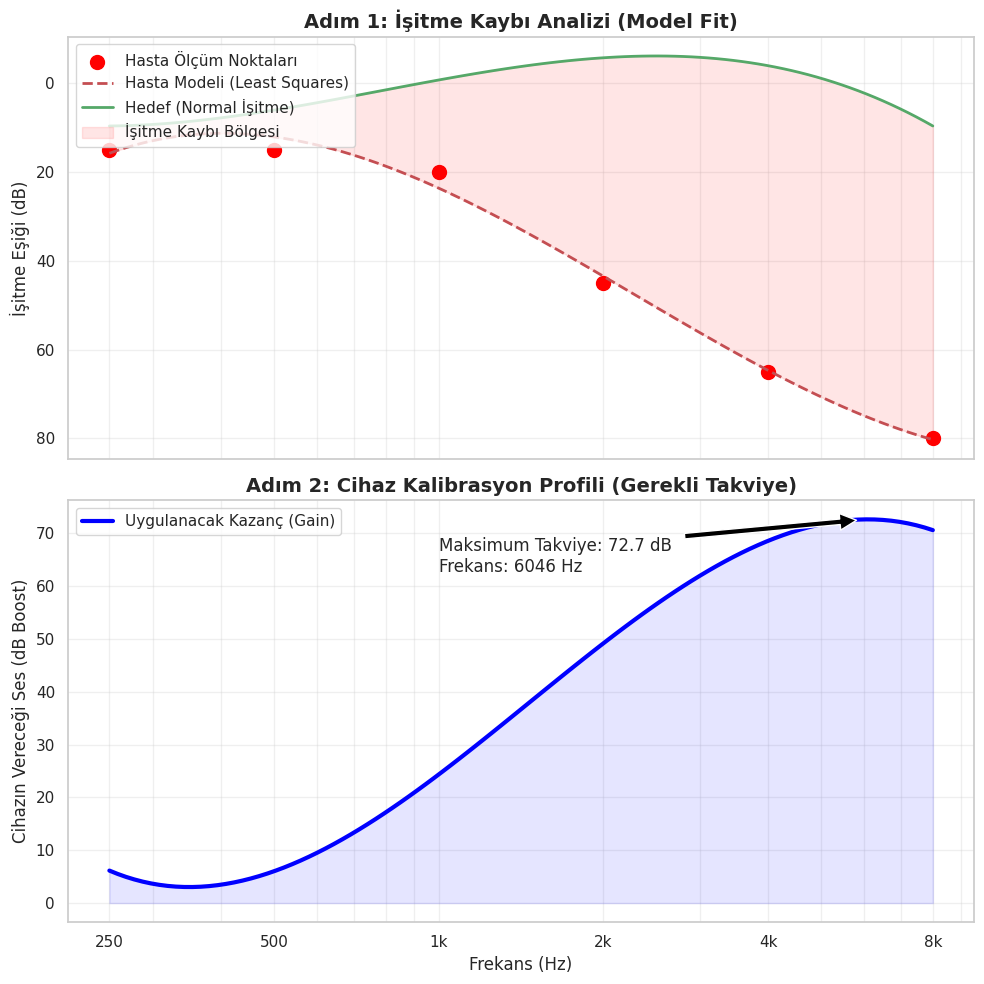

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- ÖNCEKİ FONKSİYONLARIN (QR, Solve) TANIMLI OLDUĞUNU VARSAYIYORUZ ---

def hearing_aid_calibration_demo():
    print("--- Gerçek Hayat Uygulaması: İşitme Cihazı Kalibrasyonu ---")

    # 1. HASTA SENARYOSU (Presbiakuzi - Tiz sesleri duyamama)
    # Yaşlı bir birey genellikle 2000 Hz sonrasını duymakta zorlanır.
    freqs = np.array([250, 500, 1000, 2000, 4000, 8000])

    # Normal İnsan Eşiği (Referans - Hedef)
    normal_hearing = np.array([10, 5, 0, -5, -5, 10])

    # Hasta Verisi (Ölçülen)
    patient_data = np.array([15, 15, 20, 45, 65, 80]) # Tizlerde ciddi kayıp var

    # 2. MODELLEME (Least Squares ile Eğri Uydurma)
    # Hastanın kesikli verisini sürekli bir fonksiyon haline getiriyoruz.
    x_log = np.log10(freqs)

    # 3. Derece Polinom (Yeterince esnek)
    degree = 3
    A = np.column_stack([x_log**i for i in range(degree + 1)])

    # Hastanın işitme modelini çıkar (Katsayıları bul)
    coeffs_patient = solve_least_squares_manual(A, patient_data)

    # Normal işitme modelini çıkar (Referans eğri)
    coeffs_normal = solve_least_squares_manual(A, normal_hearing)

    # 3. KALİBRASYON HESABI (Reçete Yazma)
    # Cihazın uygulaması gereken "Kazanç" (Gain) = Hasta Eşiği - Normal Eşik
    # Gain(x) = Model_Hasta(x) - Model_Normal(x)

    # Pürüzsüz çizim için frekans aralığı
    x_smooth = np.linspace(np.log10(250), np.log10(8000), 100)
    A_smooth = np.column_stack([x_smooth**i for i in range(degree + 1)])

    y_patient_smooth = np.dot(A_smooth, coeffs_patient)
    y_normal_smooth = np.dot(A_smooth, coeffs_normal)

    # KRİTİK NOKTA: İşitme cihazının ne kadar ses açması gerektiği (Gain)
    gain_curve = y_patient_smooth - y_normal_smooth
    # Negatif kazanç olmaz (zaten duyduğu yeri kısmayız), minimum 0'a sabitleriz.
    gain_curve = np.maximum(gain_curve, 0)

    # --- GÖRSELLEŞTİRME ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Üst Grafik: Hasta Durumu vs Normal
    ax1.set_title("Adım 1: İşitme Kaybı Analizi (Model Fit)", fontsize=14, fontweight='bold')
    ax1.scatter(freqs, patient_data, color='red', s=100, label='Hasta Ölçüm Noktaları')
    ax1.plot(10**x_smooth, y_patient_smooth, 'r--', linewidth=2, label='Hasta Modeli (Least Squares)')
    ax1.plot(10**x_smooth, y_normal_smooth, 'g-', linewidth=2, label='Hedef (Normal İşitme)')

    # Aradaki farkı (İşitme Kaybı) boya
    ax1.fill_between(10**x_smooth, y_normal_smooth, y_patient_smooth, color='red', alpha=0.1, label='İşitme Kaybı Bölgesi')

    ax1.set_ylabel("İşitme Eşiği (dB)")
    ax1.grid(True, which="both", alpha=0.3)
    ax1.legend(loc='upper left')
    ax1.invert_yaxis() # Odyogramlarda y ekseni genelde ters olur (aşağısı kayıp)

    # Alt Grafik: Cihazın Yapacağı İş (Gain)
    ax2.set_title("Adım 2: Cihaz Kalibrasyon Profili (Gerekli Takviye)", fontsize=14, fontweight='bold')
    ax2.plot(10**x_smooth, gain_curve, color='blue', linewidth=3, label='Uygulanacak Kazanç (Gain)')
    ax2.fill_between(10**x_smooth, 0, gain_curve, color='blue', alpha=0.1)

    ax2.set_ylabel("Cihazın Vereceği Ses (dB Boost)")
    ax2.set_xlabel("Frekans (Hz)")
    ax2.set_xscale('log')
    ax2.set_xticks([250, 500, 1000, 2000, 4000, 8000])
    ax2.set_xticklabels(['250', '500', '1k', '2k', '4k', '8k'])
    ax2.grid(True, which="both", alpha=0.3)
    ax2.legend()

    # Kritik frekansları işaretle
    max_gain_idx = np.argmax(gain_curve)
    max_gain_freq = 10**x_smooth[max_gain_idx]
    max_gain_val = gain_curve[max_gain_idx]

    ax2.annotate(f'Maksimum Takviye: {max_gain_val:.1f} dB\nFrekans: {max_gain_freq:.0f} Hz',
                 xy=(max_gain_freq, max_gain_val),
                 xytext=(1000, max_gain_val-10),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    hearing_aid_calibration_demo()

--- Bonus 1: 3D Hata Yüzeyi (Loss Landscape) ---


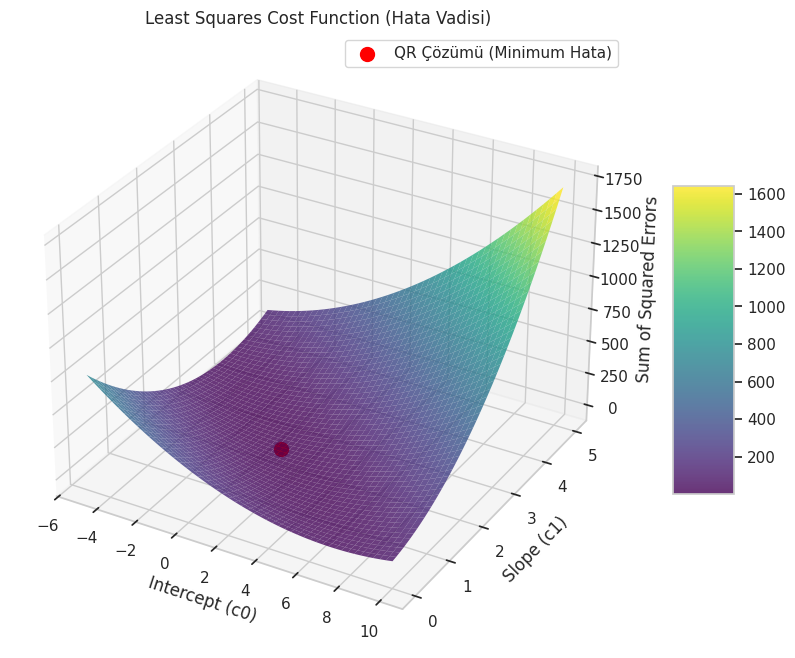

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_loss_landscape():
    print("--- Bonus 1: 3D Hata Yüzeyi (Loss Landscape) ---")

    # Basit veri: y = 2x + 1 (Lineer bir ilişki üzerinden gösterelim)
    x = np.array([1, 2, 3, 4, 5])
    y = np.array([3.1, 4.9, 7.2, 9.1, 11.0]) # Gürültülü

    # Grid oluştur (Olası c0 ve c1 değerleri)
    c0_vals = np.linspace(-5, 10, 50) # Intercept aralığı
    c1_vals = np.linspace(0, 5, 50)   # Slope aralığı
    C0, C1 = np.meshgrid(c0_vals, c1_vals)
    SSE = np.zeros_like(C0)

    # Her (c0, c1) çifti için hatayı (Sum of Squared Errors) hesapla
    for i in range(len(c0_vals)):
        for j in range(len(c1_vals)):
            y_pred = C0[i, j] + C1[i, j] * x
            SSE[i, j] = np.sum((y - y_pred)**2)

    # 3D Çizim
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Yüzey grafiği
    surf = ax.plot_surface(C0, C1, SSE, cmap='viridis', alpha=0.8, edgecolor='none')

    # En iyi çözümü (QR ile bulduğumuz) işaretle
    A = np.column_stack((np.ones(len(x)), x))
    best_coeffs = solve_least_squares_manual(A, y) # Senin fonksiyonun
    best_c0, best_c1 = best_coeffs
    min_sse = np.sum((y - (best_c0 + best_c1*x))**2)

    ax.scatter(best_c0, best_c1, min_sse, color='red', s=100, label='QR Çözümü (Minimum Hata)', zorder=10)

    ax.set_title('Least Squares Cost Function (Hata Vadisi)')
    ax.set_xlabel('Intercept (c0)')
    ax.set_ylabel('Slope (c1)')
    ax.set_zlabel('Sum of Squared Errors')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.legend()
    plt.show()

plot_loss_landscape()  #Çalıştırmak için yorumu kaldır

In [ ]:
def stability_analysis():
    print("--- Bonus 2: Nümerik Kararlılık Analizi (Neden QR?) ---")

    # Yüksek dereceli bir Vandermonde matrisi (Polinom fitting için)
    x = np.linspace(0, 1, 15) # 0 ile 1 arası
    degree = 10 # 10. derece polinom (Tehlikeli bölge)
    A = np.column_stack([x**i for i in range(degree+1)])

    # 1. A Matrisinin Kondisyon Sayısı (QR Yöntemi için geçerli)
    cond_A = np.linalg.cond(A)

    # 2. Normal Denklemler Matrisinin (A.T * A) Kondisyon Sayısı
    ATA = np.dot(A.T, A)
    cond_ATA = np.linalg.cond(ATA)

    print(f"Polinom Derecesi: {degree}")
    print(f"QR Yöntemi (cond(A)):       {cond_A:.2e}")
    print(f"Normal Denklemler (cond(ATA)): {cond_ATA:.2e}")
    print("-" * 40)
    print(f"FARK: Normal denklemler matrisi, QR'a göre {cond_ATA/cond_A:.0f} kat daha kötü koşullu!")
    print("Yorum: Bu yüzden QR Decomposition, yüksek dereceli fitting işlemlerinde çok daha güvenilirdir.")

stability_analysis()

--- Bonus 2: Nümerik Kararlılık Analizi (Neden QR?) ---
Polinom Derecesi: 10
QR Yöntemi (cond(A)):       3.35e+07
Normal Denklemler (cond(ATA)): 1.12e+15
----------------------------------------
FARK: Normal denklemler matrisi, QR'a göre 33402847 kat daha kötü koşullu!
Yorum: Bu yüzden QR Decomposition, yüksek dereceli fitting işlemlerinde çok daha güvenilirdir.


--- Bonus 3: Model Sınırları (Extrapolation) ---


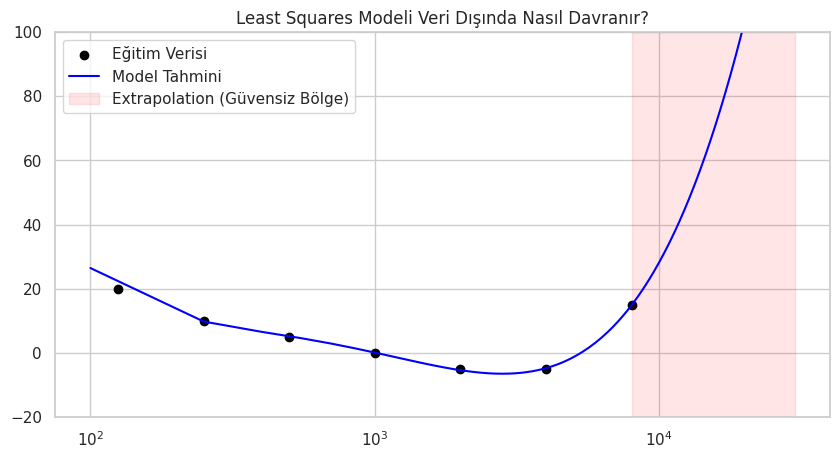

In [ ]:
def extrapolation_test():
    print("--- Bonus 3: Model Sınırları (Extrapolation) ---")

    # Veri: 20 Hz - 8000 Hz arası (Eğitim verisi)
    freqs_train = np.array([125, 250, 500, 1000, 2000, 4000, 8000])
    db_train = np.array([20, 10, 5, 0, -5, -5, 15])

    # Test: 16000 Hz ve 20000 Hz (Modelin hiç görmediği yerler)
    x_train = np.log10(freqs_train)

    # 4. Derece Model Eğit
    degree = 4
    A = np.column_stack([x_train**i for i in range(degree+1)])
    coeffs = solve_least_squares_manual(A, db_train)

    # Geleceği (Yüksek frekansları) Tahmin Et
    freqs_future = np.linspace(100, 30000, 200) # 30kHz'e kadar çiz
    x_future = np.log10(freqs_future)
    A_future = np.column_stack([x_future**i for i in range(degree+1)])
    y_future = np.dot(A_future, coeffs)

    plt.figure(figsize=(10, 5))
    plt.scatter(freqs_train, db_train, color='black', label='Eğitim Verisi')
    plt.plot(freqs_future, y_future, color='blue', label='Model Tahmini')

    # Tehlikeli bölgeyi işaretle
    plt.axvspan(8000, 30000, color='red', alpha=0.1, label='Extrapolation (Güvensiz Bölge)')

    plt.xscale('log')
    plt.ylim(-20, 100)
    plt.title('Least Squares Modeli Veri Dışında Nasıl Davranır?')
    plt.legend()
    plt.show()
extrapolation_test()

--- Bonus: Nümerik Kararlılık Karşılaştırması (Görsel) ---


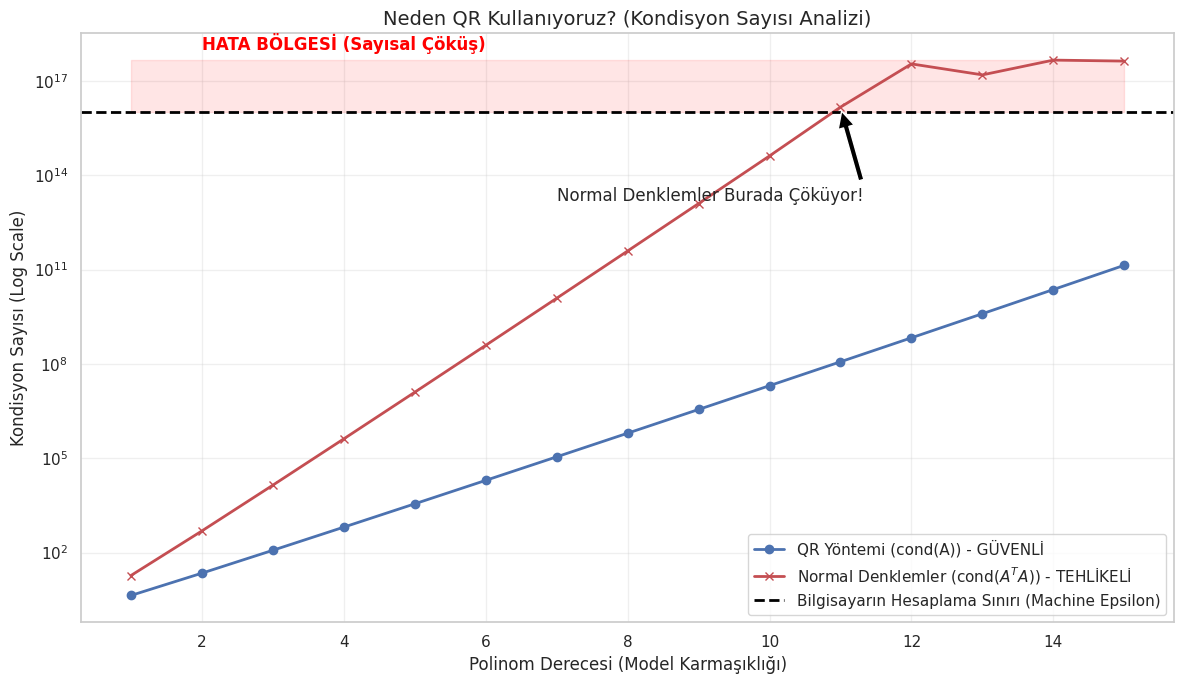

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visual_stability_analysis():
    print("--- Bonus: Nümerik Kararlılık Karşılaştırması (Görsel) ---")

    # 1 ile 15. derece arasındaki polinomları test edeceğiz
    degrees = np.arange(1, 16)

    cond_A_list = []      # QR Yöntemi için (cond(A))
    cond_ATA_list = []    # Normal Denklemler için (cond(A^T * A))

    # Simülasyon Döngüsü
    for d in degrees:
        # 0 ile 1 arasında eşit aralıklı noktalar (Vandermonde matrisi için en klasik test)
        x = np.linspace(0, 1, 50)

        # Vandermonde Matrisi Oluştur
        A = np.column_stack([x**i for i in range(d+1)])

        # 1. QR'ın Kondisyon Sayısı (cond(A))
        c_A = np.linalg.cond(A)
        cond_A_list.append(c_A)

        # 2. Normal Denklemlerin Kondisyon Sayısı (cond(A^T * A))
        # Teorik olarak bu, cond(A)'nın karesidir. Hata karesiyle artar.
        ATA = np.dot(A.T, A)
        c_ATA = np.linalg.cond(ATA)
        cond_ATA_list.append(c_ATA)

    # --- GÖRSELLEŞTİRME ---
    plt.figure(figsize=(12, 7))

    # Logaritmik Eksen (Çünkü sayılar çok hızlı büyüyor)
    plt.semilogy(degrees, cond_A_list, 'b-o', linewidth=2, label='QR Yöntemi (cond(A)) - GÜVENLİ')
    plt.semilogy(degrees, cond_ATA_list, 'r-x', linewidth=2, label='Normal Denklemler (cond($A^TA$)) - TEHLİKELİ')

    # Makine Hassasiyeti Sınırı (Machine Epsilon ~ 10^16)
    # Bu çizgiyi geçen hesaplamalar "Çöp" (Garbage) değer üretir.
    machine_epsilon = 1e16
    plt.axhline(y=machine_epsilon, color='black', linestyle='--', linewidth=2, label='Bilgisayarın Hesaplama Sınırı (Machine Epsilon)')

    # Tehlikeli Bölgeyi Boya
    plt.fill_between(degrees, machine_epsilon, max(cond_ATA_list), color='red', alpha=0.1)
    plt.text(2, 1e18, "HATA BÖLGESİ (Sayısal Çöküş)", color='red', fontsize=12, fontweight='bold')

    # Grafik Süslemeleri
    plt.title("Neden QR Kullanıyoruz? (Kondisyon Sayısı Analizi)", fontsize=14)
    plt.xlabel("Polinom Derecesi (Model Karmaşıklığı)")
    plt.ylabel("Kondisyon Sayısı (Log Scale)")
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend(loc='lower right')

    # Kritik Nokta İşaretlemesi
    # Normal denklemlerin sınırı geçtiği yer
    crash_idx = np.where(np.array(cond_ATA_list) > machine_epsilon)[0]
    if len(crash_idx) > 0:
        idx = crash_idx[0]
        plt.annotate('Normal Denklemler Burada Çöküyor!',
                     xy=(degrees[idx], cond_ATA_list[idx]),
                     xytext=(degrees[idx]-4, cond_ATA_list[idx]/1000),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visual_stability_analysis()